**OPINION SPAM DETECTION**

In [1]:
import pandas as pd
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from gensim import matutils,corpora, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings


/Users/shivakumark/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shivakumark/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
"""
#Use these comments if you're using unix based machine for moving all files in 
cd negative_polarity
find . -type f -print0 | xargs -0 -I file mv file .
rm -rf truthful_from_Web 
rm -rf deceptive_from_MTurk

cd positive_polarity
find . -type f -print0 | xargs -0 -I file mv file .
rm -rf deceptive_from_MTurk
rm -rf truthful_from_TripAdvisor """

# names of all files in the negative_polarity dir into a list
negative_review_list = os.listdir("op_spam_v1.4/negative_polarity")
# names of all files in the positive_polarity dir into a list
positive_review_list = os.listdir("op_spam_v1.4/positive_polarity")

**Data Preprocessig**

In [3]:
def pre_processor(list_of_files,root_folder,polarity_str):
    target_class = []
    actual_class = []
    reviews = []

    for file_tmp in list_of_files:
        target_class.append(polarity_str)
        review_str = str(open(root_folder + '/' + file_tmp).read())
        reviews.append(review_str)
        actual_class.append(str(file_tmp.split('_')[0]))
    data = pd.DataFrame({'target_class':target_class,'actual_class':actual_class, 'review':reviews})
    return data

In [4]:
negative_data = pre_processor(negative_review_list,'op_spam_v1.4/negative_polarity','negative')
positive_data = pre_processor(positive_review_list,'op_spam_v1.4/positive_polarity','positive')

In [5]:
negative_data.head()

,actual_class,review,target_class
0,d,Affinia Chicago is one of the worst hotels I h...,negative
1,d,I recently stayed at the Affina Chicago hotel ...,negative
2,d,I stayed at the Affina Chicago for my annivers...,negative
3,d,If you are looking for a high end hotel on the...,negative
4,d,I just returned from a long weekend in Chicago...,negative


In [6]:
positive_data.head()

,actual_class,review,target_class
0,d,"After recent week stay at the Affinia Hotels, ...",positive
1,d,"Although much too overpriced in my opinion, th...",positive
2,d,The Affinia hotel in Chicago was superb. the r...,positive
3,d,THIS HOTEL IS FANTASTIC. I stayed there on my ...,positive
4,d,The Affinia Chicago is a wonderful place to st...,positive


In [7]:
target = []
for i in negative_data.index:
    if ((negative_data['target_class'][i] == 'negative') & (negative_data['actual_class'][i] == 't')):
        target.append(3)
    elif ((negative_data['target_class'][i] == 'negative') & (negative_data['actual_class'][i] == 'd')):
        target.append(4)
    else:
        print('Error!')
negative_data['target'] = target

In [8]:
target = []
for i in positive_data.index:
    if ((positive_data['target_class'][i] == 'positive') & (positive_data['actual_class'][i] == 't')):
        target.append(2)
    elif ((positive_data['target_class'][i] == 'positive') & (positive_data['actual_class'][i] == 'd')):
        target.append(1)
    else:
        print('Error!')
positive_data['target'] = target

In [9]:
data = positive_data.merge(negative_data,how='outer')

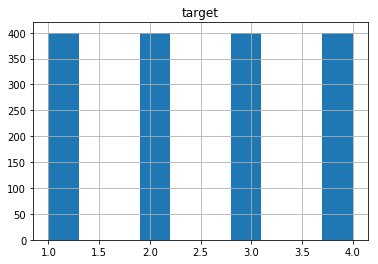

In [10]:
data = data[['review','target']]
data.head()
data.hist()
plt.show()

In [11]:
data.target.value_counts()

4    400
3    400
2    400
1    400
Name: target, dtype: int64

In [12]:
def tokenizer(dataframe):
    tokenized_review = []
    lemmatizer = WordNetLemmatizer()
    for index, datapoint in dataframe.iterrows():
        tokenized_words = word_tokenize(datapoint["review"].lower(),language='english')
        pos_tagged_word = pos_tag(tokenized_words)
        tokenize_words = ["_".join([lemmatizer.lemmatize(i[0]),i[1]]) for i in pos_tagged_word if (i[0] not in stopwords.words("english") and len(i[0]) > 2)]
        tokenized_review.append(tokenize_words)
    dataframe["tokenized_review"] = tokenized_review
    return dataframe

data = tokenizer(data)

In [14]:
data.head()

,review,target,tokenized_review
0,"After recent week stay at the Affinia Hotels, ...",1,"[recent_JJ, week_NN, stay_NN, affinia_NN, hote..."
1,"Although much too overpriced in my opinion, th...",1,"[although_IN, much_RB, overpriced_VBN, opinion..."
2,The Affinia hotel in Chicago was superb. the r...,1,"[affinia_JJ, hotel_NN, chicago_NN, superb_NN, ..."
3,THIS HOTEL IS FANTASTIC. I stayed there on my ...,1,"[hotel_NN, fantastic_JJ, stayed_VBD, way_NN, c..."
4,The Affinia Chicago is a wonderful place to st...,1,"[affinia_NN, chicago_NN, wonderful_JJ, place_N..."


In [15]:
from gensim import matutils,corpora, models

def vectorize_reviews(dataframe):
    dict = corpora.Dictionary(dataframe["tokenized_review"])
    dict.filter_extremes(no_below=2, no_above=0.8)
    dict.compactify()
    corpus = [dict.doc2bow(text) for text in dataframe["tokenized_review"]]
    corpus = matutils.corpus2csc(corpus, num_terms=len(dict.token2id))
    corpus = corpus.transpose()
    return dict, corpus

dictionary,corpus = vectorize_reviews(data)
print corpus.shape

(1600, 5911)


**Data Splitting**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(corpus, data["target"], test_size=0.25)

**RandomForestClassifier:**

In [17]:
def random_forest_classifier_trainer(X,y):
    n_estimators = [100]
    min_samples_split = [2]
    min_samples_leaf = [1]
    parameters = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split}
    classifier = GridSearchCV(RandomForestClassifier(verbose=1,n_jobs=-1), cv=4, param_grid=parameters)
    classifier.fit(X, y)
    return classifier

In [18]:
trained_rf_classfier = random_forest_classifier_trainer(X_train,y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jo

In [21]:
print ("Accuracy of RandomForestClassifier with GridSearchCV on training data is :{}".format(trained_rf_classfier.best_score_))

Accuracy of RandomForestClassifier with GridSearchCV on training data is :0.6925


In [23]:
print("Accuracy of RandomForestClassifier with GridSearchCV on test data is : {}".format(trained_rf_classfier.score(X_test,y_test)))

Accuracy of RandomForestClassifier with GridSearchCV on test data is : 0.69


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


**SVM Classifier:**

In [24]:
def svm_classifier_trainer(X,y):
    parameters = {'C': [10,15,20,25],'random_state':[2016]}
    svc_classifier = GridSearchCV(SVC(kernel = 'rbf'), cv=4, param_grid=parameters)
    svc_classifier.fit(X, y)
    return svc_classifier

In [25]:
svc_classifier = svm_classifier_trainer(X_train,y_train)

In [28]:
print("Accuracy of SVM on Training sets :{}".format(svc_classifier.best_score_))

Accuracy of SVM on Training sets :0.745


In [30]:
print("Accuracy of SVM on test sets is : {}".format(svc_classifier.score(X_test,y_test)))

Accuracy of SVM on test sets is : 0.7625


**Naive Bayes Classifier:**

In [31]:
from sklearn.naive_bayes import MultinomialNB
def naive_bayes_trainer(X,y):
    naive_bayes_classifier = MultinomialNB()
    naive_bayes_classifier.fit(X, y)
    return naive_bayes_classifier

In [32]:
naive_bayes_classifier = naive_bayes_trainer(X_train, y_train)
print naive_bayes_classifier.score(X_train, y_train)

0.973333333333


In [34]:
from sklearn.metrics import accuracy_score
predictions = naive_bayes_classifier.predict(X_test)
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))

('Accuracy score: ', '0.825')
